The goal of this notebooks is to test the performance of several models. 
I will use bag-of-words as a baseline. 
Then I will use Keras' Embedding Layer, GloVe as a pre-trained model, an LSTM and a 1D ConvNet.

Performance metrics are accuracy, precision and recall.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from keras import layers
from keras import models
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

In [3]:
# read-in the list of tokens and the vocabulary
sequences, word_index = pd.read_pickle(preprocessed_corpus_path_TF)

# Parameters

In [4]:
# Embedding Tokens

# max_words = vocabulary size = our samples - number of most frequent words.
# I set it to 10.000, although in this case there are less.
# I do this to parametise the code.
# Aleternatively, I can set it to the length of our vocabulary = word_index
max_words = 10000

# embedding_size = embedding dimensionality
embedding_size = 10

# max_len = sequence length - the text is cut off after this number of words
# in this case I define it as the maximum sequence length in our list of tokenised sequences
max_len = np.max([len(x) for x in sequences])


# Training parameters
training_samples = int(0.8 * len(train_descr['Product_Description']))
model_path = "product_descr_TF.h5"
epochs = 10
batch_size = 32

# For GloVe word-embeddings matrix (pre-trained model)
embedding_dim = 100

In [5]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_len)

In [6]:
labels = train_descr.loc[:, 'Sentiment'].to_list()

In [7]:
dimensions_labels = len(np.unique(labels))

In [8]:
labels_encoded = tf.one_hot(indices=labels, depth=dimensions_labels)

In [9]:
labels_encoded = np.asarray(labels_encoded)

In [10]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor', labels_encoded.shape)

Shape of data tensor: (6364, 33)
Shape of label tensor (6364, 4)


In [11]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [12]:
data = data[indices]
labels_encoded = labels_encoded[indices]

In [13]:
x_train = data[:training_samples]
y_train = labels_encoded[:training_samples]

x_val = data[training_samples:]
y_val = labels_encoded[training_samples:]

In [14]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

In [15]:
get_key(word_index, 2)

'sxsw'

# Bag-of-Words

* Bag-of-words will be used as a baseline model. 
* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

In [16]:
sequences_oh, word_index_oh = pd.read_pickle(preprocessed_corpus_path_TF_oh)

In [17]:
sequences_oh.shape

(6364, 10000)

In [18]:
data_oh = sequences_oh[indices]

In [19]:
x_train_oh = data_oh[:training_samples]
y_train_oh = y_train

x_val_oh = data_oh[training_samples:]
y_val_oh = y_val

# Fully Connected NN & Bag of Words

In [20]:
model_bow = models.Sequential()

model_bow.add(layers.Dense(16, activation='relu',
                       input_shape=(max_words, )))
model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(16, activation='relu'))
model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(4, activation='softmax'))

model_bow.summary()

model_bow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 160,356
Trainable params: 160,356
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_bow = model_bow.fit(
    x_train_oh, y_train_oh,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val_oh, y_val_oh)
)

Epoch 1/10
160/160 [==============================] - 0s 3ms/step - loss: 1.2472 - accuracy: 0.4879 - val_loss: 1.0327 - val_accuracy: 0.5962
Epoch 2/10
160/160 [==============================] - 0s 2ms/step - loss: 1.0797 - accuracy: 0.5645 - val_loss: 0.9335 - val_accuracy: 0.5962
Epoch 3/10
160/160 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.5718 - val_loss: 0.8888 - val_accuracy: 0.5962
Epoch 4/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9670 - accuracy: 0.5873 - val_loss: 0.8695 - val_accuracy: 0.5962
Epoch 5/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9486 - accuracy: 0.5873 - val_loss: 0.8761 - val_accuracy: 0.5962
Epoch 6/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9328 - accuracy: 0.5905 - val_loss: 0.8614 - val_accuracy: 0.5962
Epoch 7/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9186 - accuracy: 0.5895 - val_loss: 0.8468 - val_accuracy: 0.5962
Epoch 

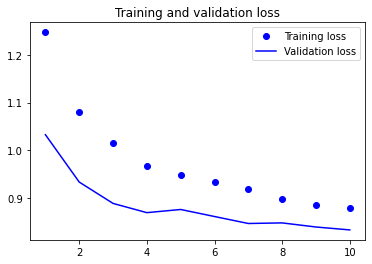

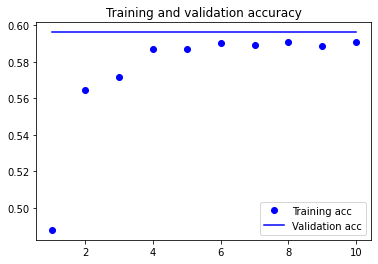

In [22]:
loss_bow = history_bow.history['loss']
val_loss_bow = history_bow.history['val_loss']
acc_bow = history_bow.history['accuracy']
val_acc_bow = history_bow.history['val_accuracy']


epochs_graph = range(1, len(acc_bow) + 1)

plt.plot(epochs_graph, loss_bow, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_bow, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_bow, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_bow, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [23]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [24]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(max_words+1,
                               embedding_size, input_length=max_len))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(32, activation='relu'))
model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(32, activation='relu'))
model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(4, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 10)            100010    
_________________________________________________________________
flatten (Flatten)            (None, 330)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                10592     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [25]:
history_emb = model_emb.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/10
160/160 [==============================] - 1s 3ms/step - loss: 1.1940 - accuracy: 0.4867 - precision: 0.5571 - recall: 0.1322 - val_loss: 0.9856 - val_accuracy: 0.5962 - val_precision: 0.6287 - val_recall: 0.2859
Epoch 2/10
160/160 [==============================] - 0s 2ms/step - loss: 1.0349 - accuracy: 0.5372 - precision: 0.5729 - recall: 0.2717 - val_loss: 0.9162 - val_accuracy: 0.5962 - val_precision: 0.6035 - val_recall: 0.5907
Epoch 3/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9755 - accuracy: 0.5683 - precision: 0.6054 - recall: 0.3640 - val_loss: 0.8913 - val_accuracy: 0.5962 - val_precision: 0.5987 - val_recall: 0.5931
Epoch 4/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9331 - accuracy: 0.5824 - precision: 0.6270 - recall: 0.4319 - val_loss: 0.8692 - val_accuracy: 0.5962 - val_precision: 0.6075 - val_recall: 0.5860
Epoch 5/10
160/160 [==============================] - 0s 2ms/step - loss: 0.8862 - accuracy: 0.5877 - pr

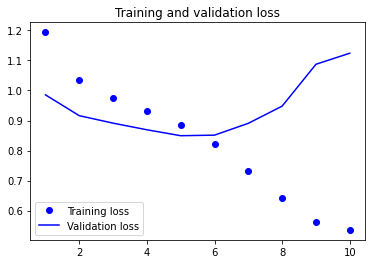

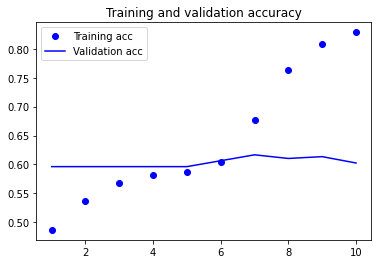

In [26]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs_graph = range(1, len(acc_emb) + 1)

plt.plot(epochs_graph, loss_emb, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_emb, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Pre-Trained Embeddings Layer

In [27]:
glove_dir = './glove.6B'

In [28]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_matrix = np.zeros((max_words+1, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


In [30]:
model_transf = models.Sequential()

model_transf.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_transf.add(layers.Flatten())
model_transf.add(layers.Dense(16, activation='relu'))
model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(16, activation='relu'))
model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(4, activation='softmax'))

model_transf.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_transf.layers[0].trainable = False


# needed in order to save the weights: https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary
model_transf.build((max_len,))

model_transf.summary()


model_transf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3300)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                52816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [31]:
history_transf = model_transf.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

model_transf.save_weights(f'{model_path}_transf')

Epoch 1/10
160/160 [==============================] - 1s 4ms/step - loss: 1.2979 - accuracy: 0.5536 - precision: 0.5881 - recall: 0.1196 - val_loss: 1.1643 - val_accuracy: 0.5962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
160/160 [==============================] - 0s 2ms/step - loss: 1.1127 - accuracy: 0.5791 - precision: 0.5892 - recall: 0.0947 - val_loss: 1.0051 - val_accuracy: 0.5962 - val_precision: 1.0000 - val_recall: 7.8555e-04
Epoch 3/10
160/160 [==============================] - 0s 2ms/step - loss: 1.0386 - accuracy: 0.5899 - precision: 0.5834 - recall: 0.2123 - val_loss: 0.9439 - val_accuracy: 0.5962 - val_precision: 0.5959 - val_recall: 0.5954
Epoch 4/10
160/160 [==============================] - 0s 2ms/step - loss: 1.0122 - accuracy: 0.5903 - precision: 0.5959 - recall: 0.3062 - val_loss: 0.9235 - val_accuracy: 0.5962 - val_precision: 0.5962 - val_recall: 0.5962
Epoch 5/10
160/160 [==============================] - 0s 2ms/step - loss: 0.9951 - accuracy:

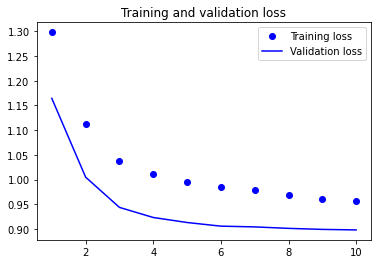

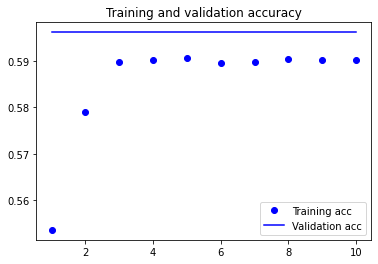

In [32]:
loss_transf = history_transf.history['loss']
val_loss_transf = history_transf.history['val_loss']
acc_transf = history_transf.history['accuracy']
val_acc_transf = history_transf.history['val_accuracy']


epochs_graph = range(1, len(acc_transf) + 1)

plt.plot(epochs_graph, loss_transf, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_transf, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_transf, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_transf, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# LSTM

In [33]:
model_lstm = models.Sequential()

model_lstm.add(layers.Embedding(max_words+1,
                                embedding_dim, input_length=max_len))

# model_lstm.add(layers.Flatten())
# Option 1
model_lstm.add(layers.LSTM(32))

# Option 2
# model.add(layers.LSTM(32, return_sequences=True)) # stacking of LSTMs
# model.add(layers.LSTM(32)) # the size of the hidden state, randomly defined
model_lstm.add(layers.Dense(16, activation='relu'))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(16, activation='relu'))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(4, activation='softmax'))

model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_lstm.layers[0].trainable = False

model_lstm.summary()

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

In [34]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/10
160/160 [==============================] - 2s 14ms/step - loss: 1.1783 - accuracy: 0.4873 - precision: 0.5888 - recall: 0.2277 - val_loss: 0.9582 - val_accuracy: 0.5962 - val_precision: 0.6722 - val_recall: 0.2852
Epoch 2/10
160/160 [==============================] - 2s 12ms/step - loss: 1.0259 - accuracy: 0.5620 - precision: 0.6118 - recall: 0.2736 - val_loss: 0.8958 - val_accuracy: 0.5962 - val_precision: 0.6519 - val_recall: 0.4501
Epoch 3/10
160/160 [==============================] - 2s 11ms/step - loss: 0.9760 - accuracy: 0.5814 - precision: 0.6340 - recall: 0.3416 - val_loss: 0.8782 - val_accuracy: 0.5962 - val_precision: 0.6640 - val_recall: 0.4595
Epoch 4/10
160/160 [==============================] - 2s 10ms/step - loss: 0.9530 - accuracy: 0.5914 - precision: 0.6550 - recall: 0.3789 - val_loss: 0.8567 - val_accuracy: 0.5962 - val_precision: 0.6438 - val_recall: 0.5169
Epoch 5/10
160/160 [==============================] - 2s 10ms/step - loss: 0.9175 - accuracy: 0.5883

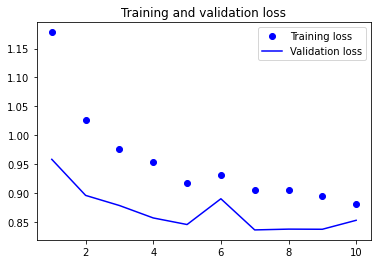

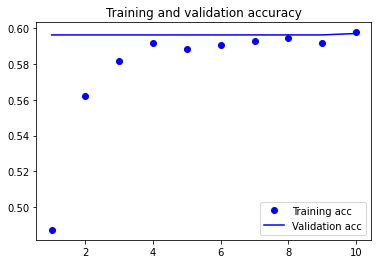

In [35]:
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
acc_lstm = history_lstm.history['accuracy']
val_acc_lstm = history_lstm.history['val_accuracy']


epochs_graph = range(1, len(acc_lstm) + 1)

plt.plot(epochs_graph, loss_lstm, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_lstm, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 1D Convolutional NN

In [36]:
model_conv1d = models.Sequential()

model_conv1d.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_conv1d.add(layers.Conv1D(
    32,  # features to be extracted
    5,  # convolutional window size
    activation='relu',
))
model_conv1d.add(layers.MaxPooling1D(3))
model_conv1d.add(layers.Conv1D(32, 5, activation='relu'))
model_conv1d.add(layers.GlobalMaxPooling1D())
model_conv1d.add(layers.Dense(4, activation='softmax'))

model_conv1d.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_conv1d.layers[0].trainable = False

model_conv1d.summary()

model_conv1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 32)            16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
_______________________________________

In [37]:
history_conv1d = model_conv1d.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/10
160/160 [==============================] - 1s 5ms/step - loss: 0.9549 - accuracy: 0.5809 - precision: 0.6204 - recall: 0.4596 - val_loss: 0.8644 - val_accuracy: 0.6033 - val_precision: 0.6187 - val_recall: 0.5342
Epoch 2/10
160/160 [==============================] - 1s 3ms/step - loss: 0.8518 - accuracy: 0.6335 - precision: 0.6703 - recall: 0.5435 - val_loss: 0.8384 - val_accuracy: 0.6143 - val_precision: 0.6377 - val_recall: 0.5585
Epoch 3/10
160/160 [==============================] - 1s 3ms/step - loss: 0.7893 - accuracy: 0.6753 - precision: 0.7094 - recall: 0.5962 - val_loss: 0.8290 - val_accuracy: 0.6002 - val_precision: 0.6359 - val_recall: 0.5310
Epoch 4/10
160/160 [==============================] - 1s 4ms/step - loss: 0.7212 - accuracy: 0.7046 - precision: 0.7510 - recall: 0.6421 - val_loss: 0.8317 - val_accuracy: 0.6143 - val_precision: 0.6609 - val_recall: 0.5130
Epoch 5/10
160/160 [==============================] - 1s 3ms/step - loss: 0.6490 - accuracy: 0.7462 - pr

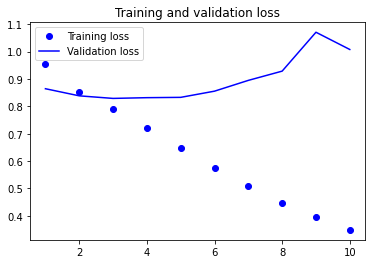

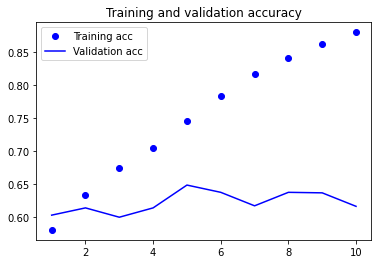

In [38]:
loss_conv1d = history_conv1d.history['loss']
val_loss_conv1d = history_conv1d.history['val_loss']
acc_conv1d = history_conv1d.history['accuracy']
val_acc_conv1d = history_conv1d.history['val_accuracy']


epochs_graph = range(1, len(acc_conv1d) + 1)

plt.plot(epochs_graph, loss_conv1d, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_conv1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_conv1d, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_conv1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()